In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="paper") 

df = pd.read_csv("base_dataset_2023_2025.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.head()

,city_id,city_name,lat,lon,datetime,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone
0,7701354,Azimpur,23.7298,90.3854,2023-01-01 00:00:00,220.7,154.1,1190.0,87.2,38.2,3.0
1,7701354,Azimpur,23.7298,90.3854,2023-01-01 01:00:00,213.7,149.0,1227.0,84.9,35.5,4.0
2,7701354,Azimpur,23.7298,90.3854,2023-01-01 02:00:00,205.4,143.4,1276.0,81.6,31.9,5.0
3,7701354,Azimpur,23.7298,90.3854,2023-01-01 03:00:00,201.6,140.6,1259.0,73.7,29.6,18.0
4,7701354,Azimpur,23.7298,90.3854,2023-01-01 04:00:00,193.2,134.6,1111.0,63.0,33.0,44.0


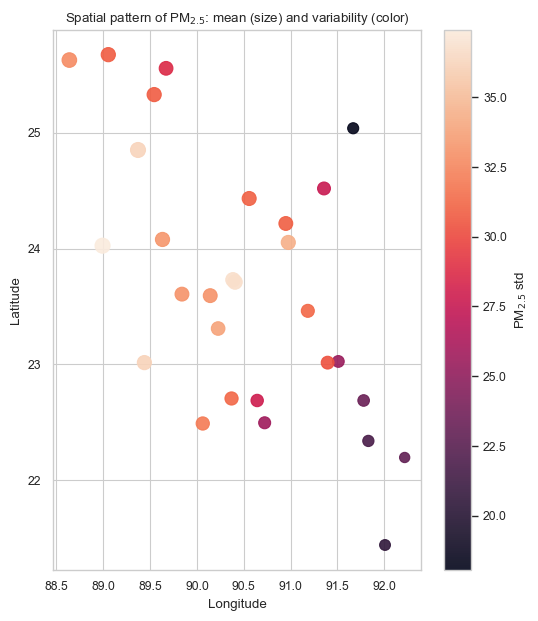

In [2]:
cities = df.drop_duplicates("city_name")[["city_name","lat","lon"]].copy()

stats = (df.groupby("city_name")["pm2_5"]
           .agg(mean="mean", std="std", p95=lambda x: np.percentile(x,95))
           .reset_index())

m = cities.merge(stats, on="city_name", how="left")

plt.figure(figsize=(5.5, 6.3))
plt.scatter(m["lon"], m["lat"], s=10 + 2.0*m["mean"], c=m["std"], alpha=0.9)
plt.colorbar(label="PM$_{2.5}$ std")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("Spatial pattern of PM$_{2.5}$: mean (size) and variability (color)")
plt.tight_layout()
#plt.savefig("Fig_bubble_map_pm25_mean_std.png", dpi=300, bbox_inches="tight")
plt.show()


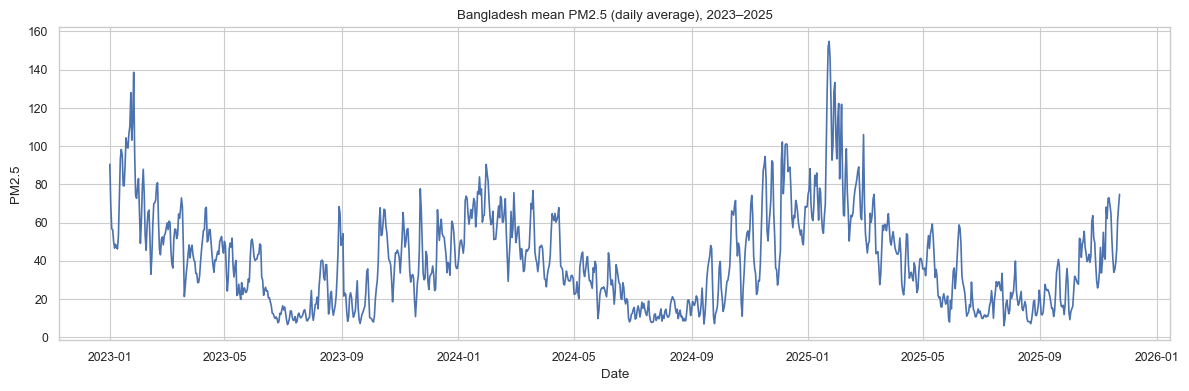

In [3]:
# National mean PM2.5 time series + seasonal trend

daily = (df.groupby(pd.Grouper(key="datetime", freq="D"))["pm2_5"]
           .mean()
           .reset_index())

plt.figure(figsize=(12, 4))
plt.plot(daily["datetime"], daily["pm2_5"])
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title("Bangladesh mean PM2.5 (daily average), 2023–2025")
plt.tight_layout()
#plt.savefig("fig_pm25_daily_mean.png", dpi=300, bbox_inches="tight")
plt.show()

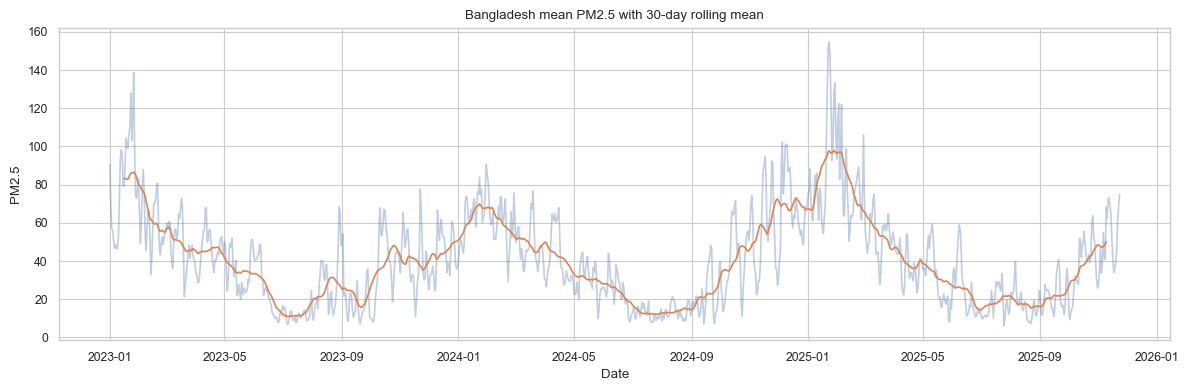

In [4]:
# Rolling of the Above Image

daily["pm2_5_rolling"] = daily["pm2_5"].rolling(30, center=True).mean()

plt.figure(figsize=(12, 4))
plt.plot(daily["datetime"], daily["pm2_5"], alpha=0.35)
plt.plot(daily["datetime"], daily["pm2_5_rolling"])
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title("Bangladesh mean PM2.5 with 30-day rolling mean")
plt.tight_layout()
#plt.savefig("fig_pm25_daily_rolling.png", dpi=300, bbox_inches="tight")
plt.show()

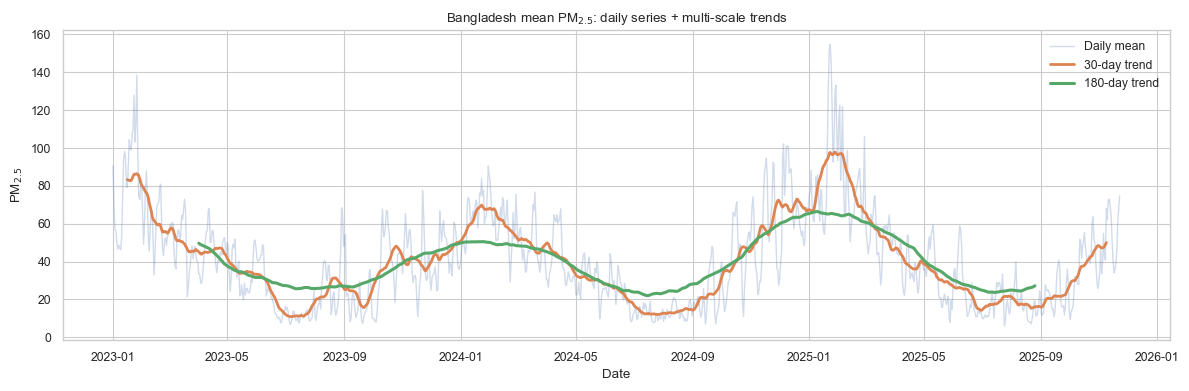

In [5]:
daily = df.groupby(pd.Grouper(key="datetime", freq="D"))["pm2_5"].mean()

roll30  = daily.rolling(30, center=True).mean()
roll180 = daily.rolling(180, center=True).mean()

plt.figure(figsize=(12, 4))
plt.plot(daily.index, daily.values, alpha=0.25, linewidth=1, label="Daily mean")
plt.plot(roll30.index, roll30.values, linewidth=2, label="30-day trend")
plt.plot(roll180.index, roll180.values, linewidth=2.2, label="180-day trend")
plt.xlabel("Date")
plt.ylabel("PM$_{2.5}$")
plt.title("Bangladesh mean PM$_{2.5}$: daily series + multi-scale trends")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_12140\2695125913.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


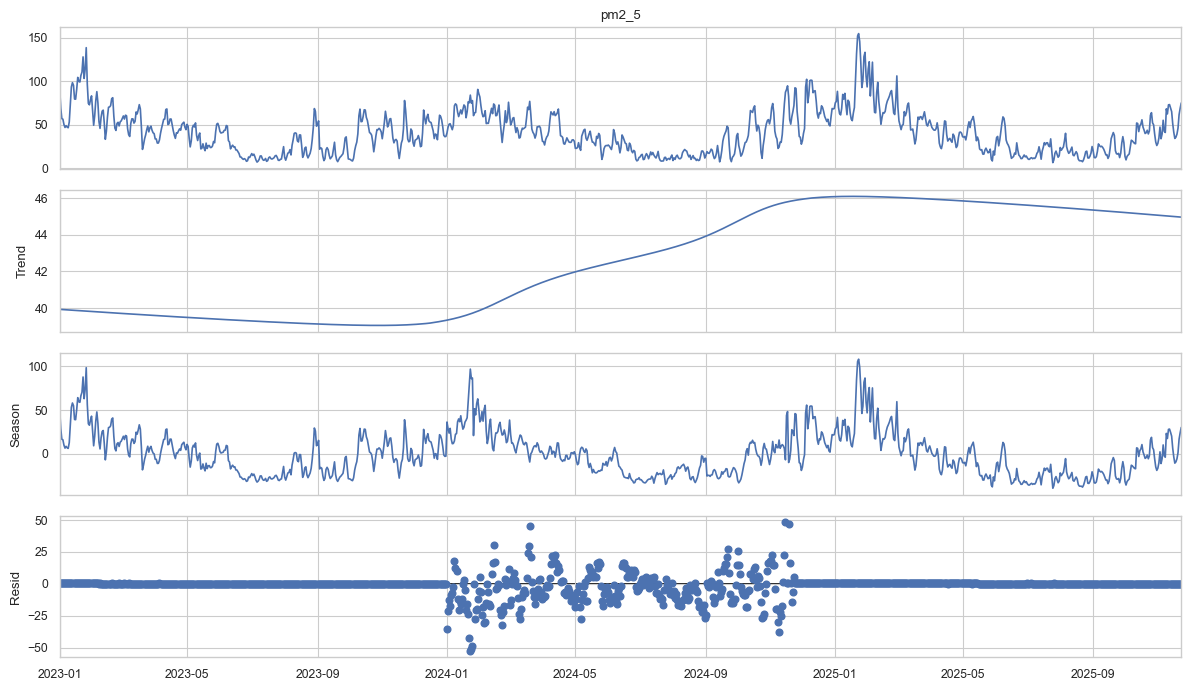

In [5]:
from statsmodels.tsa.seasonal import STL

daily = df.groupby(pd.Grouper(key="datetime", freq="D"))["pm2_5"].mean()
daily = daily.asfreq("D")  # ensure regular frequency

# period=365 for annual seasonality on daily data
stl = STL(daily, period=365, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12, 7)
plt.tight_layout()
plt.show()

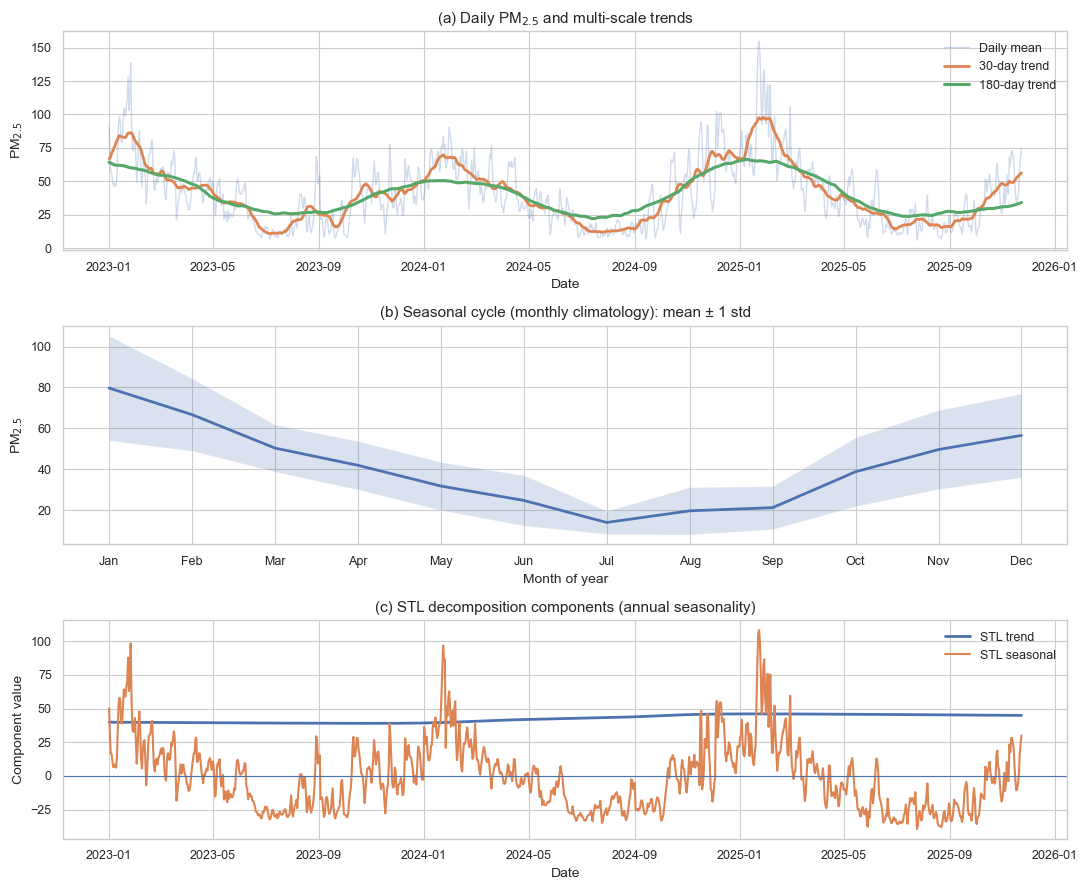

In [15]:
# --- 1) Daily national mean ---
daily = df.groupby(pd.Grouper(key="datetime", freq="D"))["pm2_5"].mean()
daily = daily.asfreq("D")  # regular daily frequency

# --- 2) Trend lines (multi-scale) ---
roll30  = daily.rolling(30, center=True, min_periods=1).mean()
roll180 = daily.rolling(180, center=True, min_periods=1).mean()

# --- 3) Seasonal climatology (monthly mean ± std) ---
daily_df = daily.reset_index()
daily_df["month"] = daily_df["datetime"].dt.month

m = daily_df.groupby("month")["pm2_5"].agg(["mean", "std"]).reset_index()
m["month_name"] = pd.to_datetime(m["month"], format="%m").dt.strftime("%b")

# --- 4) STL decomposition (annual seasonality) ---
stl = STL(daily, period=365, robust=True)
res = stl.fit()

# --- 5) Multi-panel Nature/Elsevier style figure ---
plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=False)

# (a) Daily + trend
ax = axes[0]
ax.plot(daily.index, daily.values, alpha=0.25, linewidth=1.0, label="Daily mean")
ax.plot(roll30.index, roll30.values, linewidth=2.0, label="30-day trend")
ax.plot(roll180.index, roll180.values, linewidth=2.2, label="180-day trend")
ax.set_title("(a) Daily PM$_{2.5}$ and multi-scale trends")
ax.set_xlabel("Date")
ax.set_ylabel("PM$_{2.5}$")
ax.legend(frameon=False, loc="upper right")

# (b) Monthly climatology
ax = axes[1]
ax.plot(m["month"], m["mean"], linewidth=2.0)
ax.fill_between(m["month"], m["mean"] - m["std"], m["mean"] + m["std"], alpha=0.2)
ax.set_xticks(m["month"])
ax.set_xticklabels(m["month_name"])
ax.set_title("(b) Seasonal cycle (monthly climatology): mean ± 1 std")
ax.set_xlabel("Month of year")
ax.set_ylabel("PM$_{2.5}$")

# (c) STL components (trend/seasonal/residual) in one panel: show trend + seasonal only for clarity
ax = axes[2]
ax.plot(res.trend.index, res.trend.values, linewidth=2.0, label="STL trend")
ax.plot(res.seasonal.index, res.seasonal.values, linewidth=1.5, label="STL seasonal")
ax.axhline(0, linewidth=0.8)
ax.set_title("(c) STL decomposition components (annual seasonality)")
ax.set_xlabel("Date")
ax.set_ylabel("Component value")
ax.legend(frameon=False, loc="upper right")

plt.tight_layout()
#plt.savefig("Fig_PM25_trend_season_STL.png", dpi=300, bbox_inches="tight")
#plt.savefig("Fig_PM25_trend_season_STL.pdf", bbox_inches="tight")
plt.savefig("Fig_PM25_trend_season_STL.tiff", dpi=600, bbox_inches="tight", facecolor="white", pil_kwargs={"compression": "tiff_lzw"})

plt.show()

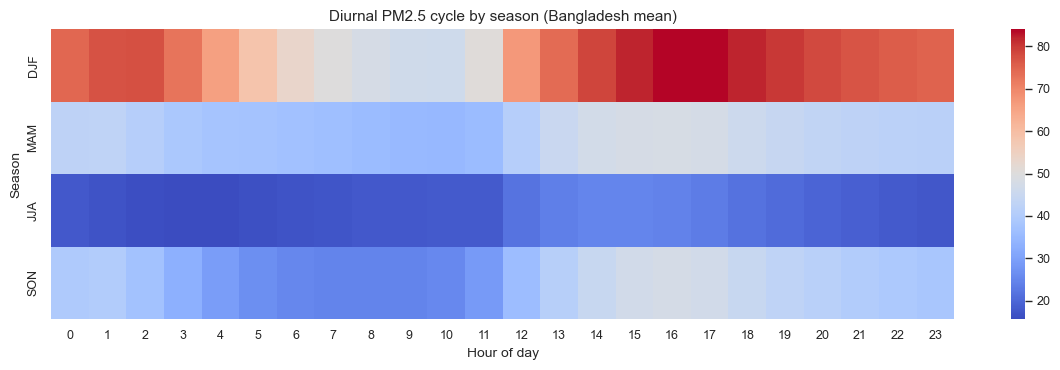

In [19]:
# Diurnal Cycle by season

tmp = df.copy()
tmp["hour"] = tmp["datetime"].dt.hour
tmp["month"] = tmp["datetime"].dt.month

# seasonal grouping: DJF/MAM/JJA/SON
def season(m):
    if m in [12,1,2]: return "DJF"
    if m in [3,4,5]: return "MAM"
    if m in [6,7,8]: return "JJA"
    return "SON"

tmp["season"] = tmp["month"].apply(season)

# Bangladesh-wide mean by season and hour
hm = (tmp.groupby(["season","hour"])["pm2_5"]
        .mean()
        .reset_index()
        .pivot(index="season", columns="hour", values="pm2_5")
        .reindex(["DJF","MAM","JJA","SON"]))

plt.figure(figsize=(12, 3.8))
sns.heatmap(hm, cmap="coolwarm")
plt.xlabel("Hour of day")
plt.ylabel("Season")
plt.title("Diurnal PM2.5 cycle by season (Bangladesh mean)")
plt.tight_layout()
#plt.savefig("fig_diurnal_season_heatmap.png", dpi=300, bbox_inches="tight")
plt.savefig("Fig_diurnal_season_heatmap.tiff", dpi=600, bbox_inches="tight", facecolor="white", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

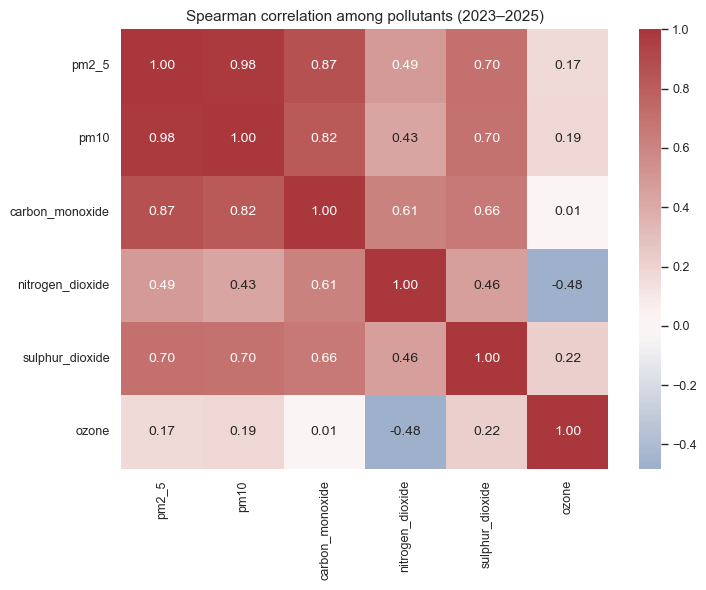

In [17]:
poll_cols = ["pm2_5","pm10","carbon_monoxide","nitrogen_dioxide","sulphur_dioxide","ozone"]
corr = df[poll_cols].corr(method="spearman")

plt.figure(figsize=(7.5, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Spearman correlation among pollutants (2023–2025)")
plt.tight_layout()
#plt.savefig("fig_corr_heatmap.png", dpi=300, bbox_inches="tight")
plt.savefig("Fig_corr_heatmap.tiff", dpi=600, bbox_inches="tight", facecolor="white", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

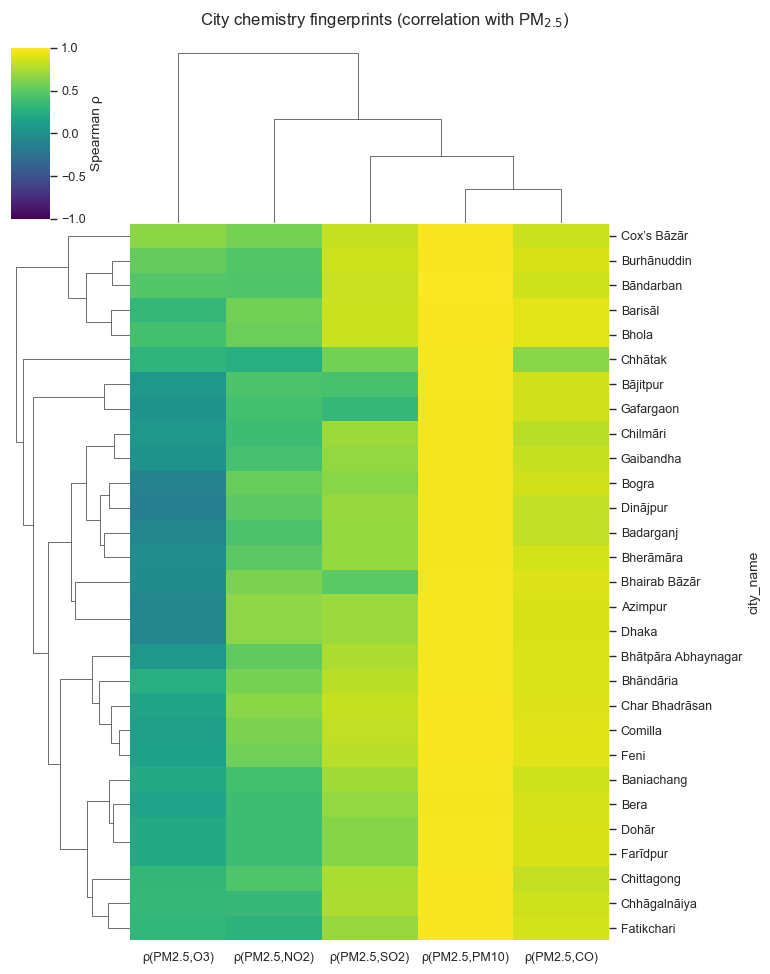

In [16]:
poll_cols = ["pm2_5","pm10","carbon_monoxide","nitrogen_dioxide","sulphur_dioxide","ozone"]

rows = []
for city, g in df.groupby("city_name"):
    C = g[poll_cols].corr(method="spearman")
    fp = C.loc["pm2_5", ["pm10","carbon_monoxide","nitrogen_dioxide","sulphur_dioxide","ozone"]]
    rows.append([city] + fp.values.tolist())

fp_df = pd.DataFrame(
    rows,
    columns=["city_name","ρ(PM2.5,PM10)","ρ(PM2.5,CO)","ρ(PM2.5,NO2)","ρ(PM2.5,SO2)","ρ(PM2.5,O3)"]
).set_index("city_name")

# seaborn clustermap creates its own figure
g = sns.clustermap(fp_df, cmap="viridis", vmin=-1, vmax=1, figsize=(7.8, 9.5),
                   cbar_kws={"label":"Spearman ρ"})
g.fig.suptitle("City chemistry fingerprints (correlation with PM$_{2.5}$)", y=1.02)
#plt.savefig("Fig5_city_fingerprint_clustermap.png", dpi=600, bbox_inches="tight")
plt.savefig("Fig_city_fingerprint_clustermap.tiff", dpi=600, bbox_inches="tight", facecolor="white", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

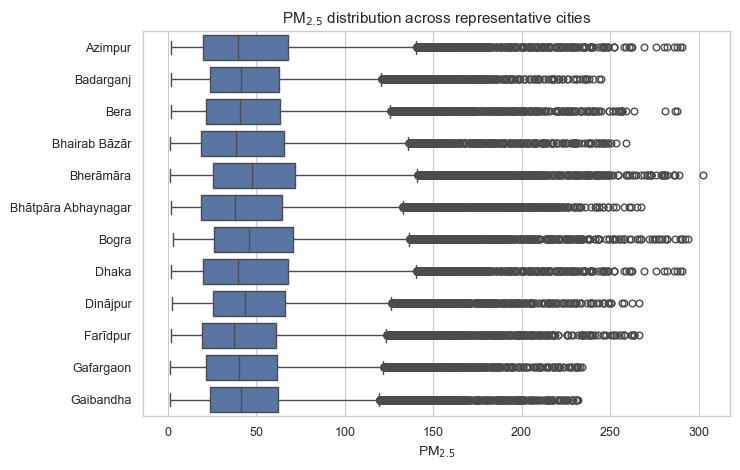

In [11]:
# top 12 cities by mean PM2.5 for readability
top12 = df.groupby("city_name")["pm2_5"].mean().sort_values(ascending=False).head(12).index
sub = df[df["city_name"].isin(top12)].copy()

fig, ax = plt.subplots(figsize=(7.5, 4.8))
sns.boxplot(data=sub, x="pm2_5", y="city_name", orient="h")
ax.set_xlabel("PM$_{2.5}$")
ax.set_ylabel("")
ax.set_title("PM$_{2.5}$ distribution across representative cities")
plt.tight_layout()
plt.savefig("FigX_pm25_city_boxplot.pdf", bbox_inches="tight")
plt.savefig("FigX_pm25_city_boxplot.png", bbox_inches="tight")
plt.show()

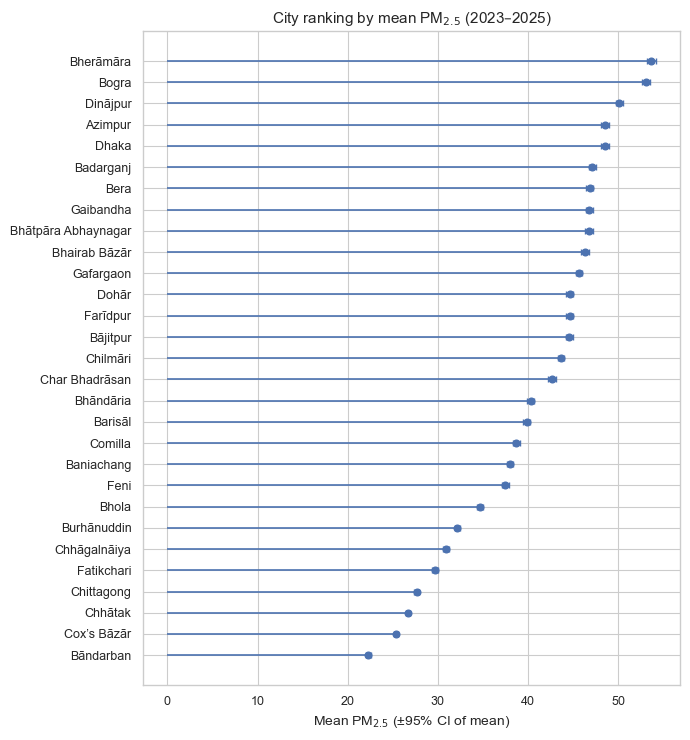

In [12]:
city_summary = (df.groupby("city_name")["pm2_5"]
                  .agg(mean="mean", std="std", n="count")
                  .reset_index())

city_summary["se"] = city_summary["std"] / np.sqrt(city_summary["n"])
city_summary = city_summary.sort_values("mean", ascending=True)

plt.figure(figsize=(7.0, 7.5))
y = np.arange(len(city_summary))
plt.hlines(y, 0, city_summary["mean"], linewidth=1.2)
plt.plot(city_summary["mean"], y, "o")
plt.errorbar(city_summary["mean"], y, xerr=1.96*city_summary["se"], fmt="none", capsize=2)

plt.yticks(y, city_summary["city_name"])
plt.xlabel("Mean PM$_{2.5}$ (±95% CI of mean)")
plt.title("City ranking by mean PM$_{2.5}$ (2023–2025)")
plt.tight_layout()
#plt.savefig("Fig_city_lollipop_pm25.png", dpi=300, bbox_inches="tight")
plt.show()

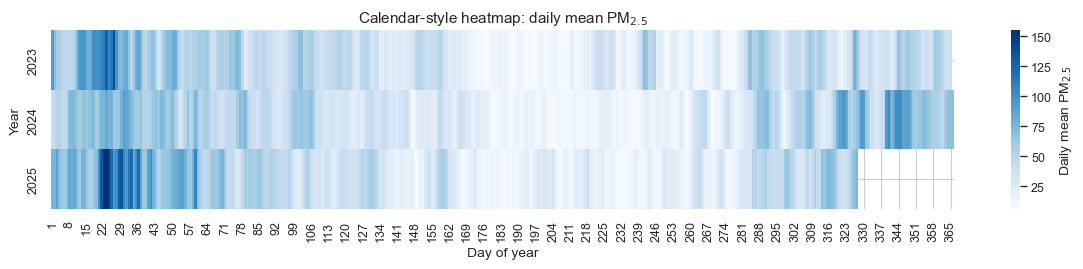

In [13]:
daily = (df.groupby(pd.Grouper(key="datetime", freq="D"))["pm2_5"]
           .mean()
           .reset_index())
daily["year"] = daily["datetime"].dt.year
daily["doy"]  = daily["datetime"].dt.dayofyear

# Make a year × day-of-year matrix
cal = daily.pivot(index="year", columns="doy", values="pm2_5")

plt.figure(figsize=(12, 2.8))
sns.heatmap(cal, cmap="Blues", cbar_kws={"label":"Daily mean PM$_{2.5}$"})
plt.xlabel("Day of year")
plt.ylabel("Year")
plt.title("Calendar-style heatmap: daily mean PM$_{2.5}$")
plt.tight_layout()
#plt.savefig("Fig_calendar_heatmap_pm25.png", dpi=300, bbox_inches="tight")
plt.show()

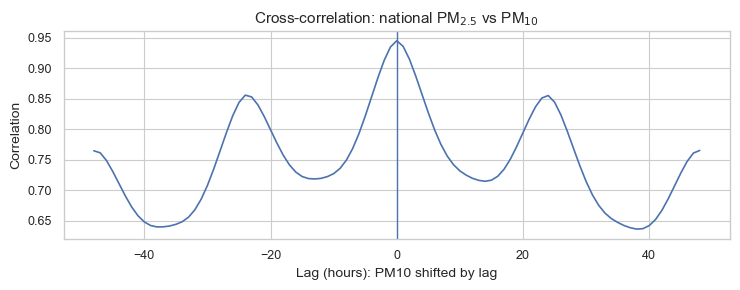

In [14]:
# national means
nat = df.groupby("datetime")[["pm2_5","pm10"]].mean().sort_index()

x = nat["pm2_5"].values
y = nat["pm10"].values

# cross-correlation for lags [-48, +48] hours
max_lag = 48
lags = np.arange(-max_lag, max_lag+1)

def corr_at_lag(x, y, lag):
    if lag < 0:
        return np.corrcoef(x[:lag], y[-lag:])[0,1]
    if lag > 0:
        return np.corrcoef(x[lag:], y[:-lag])[0,1]
    return np.corrcoef(x, y)[0,1]

cc = np.array([corr_at_lag(x, y, lag) for lag in lags])

plt.figure(figsize=(7.5, 3.0))
plt.plot(lags, cc)
plt.axvline(0, linewidth=1)
plt.xlabel("Lag (hours): PM10 shifted by lag")
plt.ylabel("Correlation")
plt.title("Cross-correlation: national PM$_{2.5}$ vs PM$_{10}$")
plt.tight_layout()
#plt.savefig("Fig_xcorr_pm25_pm10.png", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
print("Global min:", df["datetime"].min())
print("Global max:", df["datetime"].max())

# confirm per-city same last timestamp
last_by_city = df.groupby("city_name")["datetime"].max().sort_values()
print("\nLast timestamp per city (min to max):")
print(last_by_city.head(3))
print(last_by_city.tail(3))

Global min: 2023-01-01 00:00:00
Global max: 2025-11-23 23:00:00

Last timestamp per city (min to max):
city_name
Azimpur      2025-11-23 23:00:00
Feni         2025-11-23 23:00:00
Fatikchari   2025-11-23 23:00:00
Name: datetime, dtype: datetime64[ns]
city_name
Badarganj   2025-11-23 23:00:00
Bāndarban   2025-11-23 23:00:00
Gaibandha   2025-11-23 23:00:00
Name: datetime, dtype: datetime64[ns]


In [16]:
start = pd.Timestamp("2023-01-01 00:00:00")
end   = pd.Timestamp("2025-11-23 23:00:00")

# daily mean series
daily = df.groupby(pd.Grouper(key="datetime", freq="D"))["pm2_5"].mean()

# expected daily index
expected_days = pd.date_range(start.normalize(), end.normalize(), freq="D")

missing_days = expected_days.difference(daily.index)
print("Expected days:", len(expected_days))
print("Actual days:  ", len(daily.index))
print("Missing days:", len(missing_days))
if len(missing_days) > 0:
    print(missing_days[:10])

Expected days: 1058
Actual days:   1058
Missing days: 0


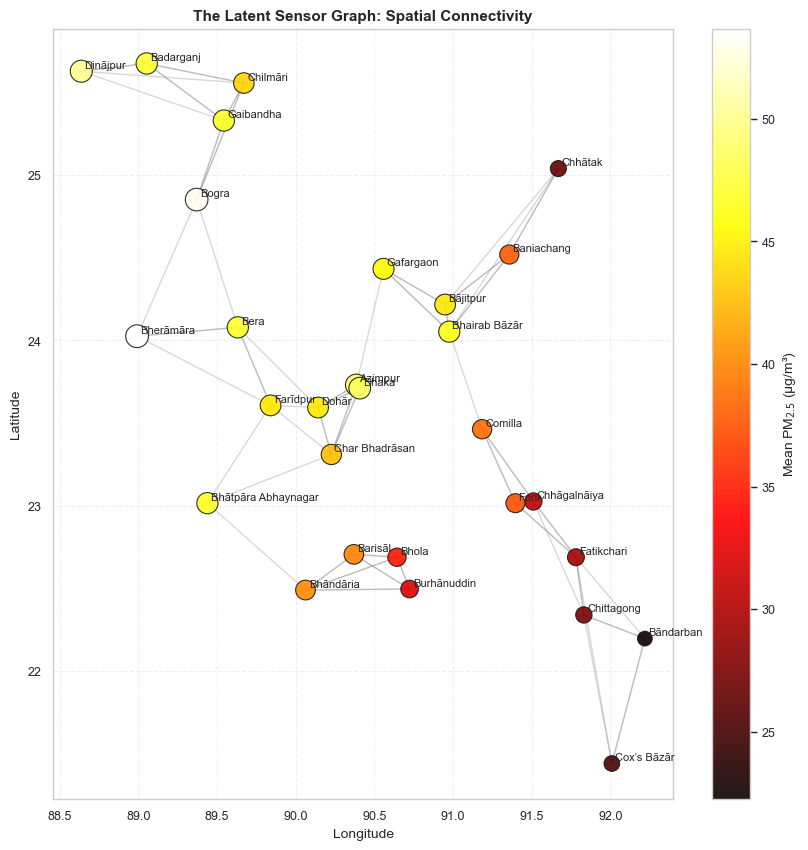

In [17]:
from sklearn.neighbors import NearestNeighbors

def plot_latent_graph(main_df):
    # 1. Safe Aggregation
    city_coords = main_df.groupby('city_name')[['lat', 'lon']].median().reset_index()
    coords = city_coords[['lat', 'lon']].values
    
    # 2. k-NN Graph
    nbrs = NearestNeighbors(n_neighbors=4).fit(np.radians(coords))
    distances, indices = nbrs.kneighbors(np.radians(coords))
    
    plt.figure(figsize=(10, 10))
    
    # 3. Plot Edges
    for i in range(len(city_coords)):
        for j in indices[i, 1:]:
            p1 = city_coords.iloc[i]
            p2 = city_coords.iloc[j]
            plt.plot([p1['lon'], p2['lon']], [p1['lat'], p2['lat']], 
                     c='gray', alpha=0.3, linewidth=1, zorder=1)
            
    # 4. Plot Nodes
    mean_pm = main_df.groupby('city_name')['pm2_5'].mean().values
    plt.scatter(city_coords['lon'], city_coords['lat'], 
                s=mean_pm*5, c=mean_pm, cmap='hot', 
                edgecolor='k', zorder=2, alpha=0.9)
    
    # Labels
    for i, row in city_coords.iterrows():
        plt.text(row['lon']+0.02, row['lat']+0.02, row['city_name'], fontsize=8)
        
    plt.title("The Latent Sensor Graph: Spatial Connectivity", weight='bold')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Mean PM$_{2.5}$ (µg/m³)")
    plt.grid(True, linestyle='--', alpha=0.3)
    
    #plt.savefig('Figure3_SensorGraph.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Usage
plot_latent_graph(df)

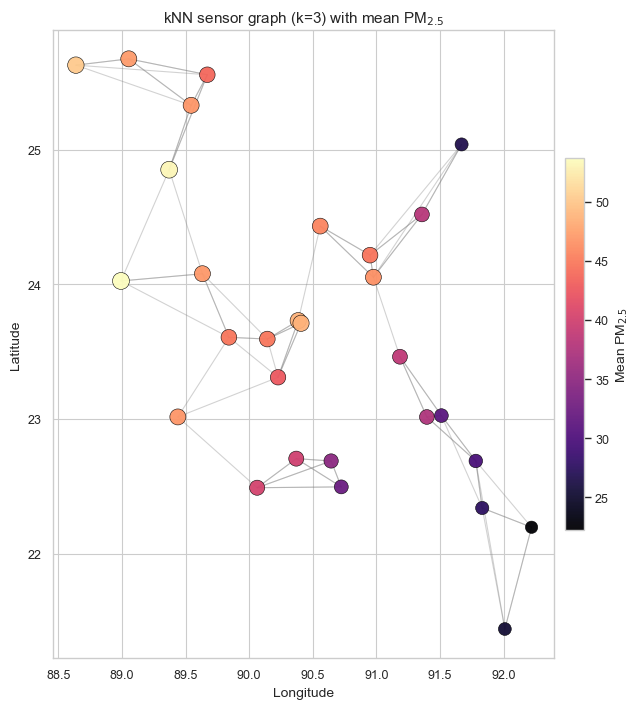

In [18]:
from sklearn.neighbors import NearestNeighbors

# City coords (unique)
city_coords = df.groupby("city_name")[["lat", "lon"]].median().reset_index()
city_coords = city_coords.sort_values("city_name").reset_index(drop=True)

# City mean PM2.5 for node size/color
mean_pm25 = df.groupby("city_name")["pm2_5"].mean()
city_coords["mean_pm25"] = city_coords["city_name"].map(mean_pm25)

# Build kNN in meters (approx conversion)
lat0 = city_coords["lat"].mean()
m_per_deg_lat = 111320.0
m_per_deg_lon = 111320.0 * np.cos(np.deg2rad(lat0))

xy = np.c_[city_coords["lon"].values * m_per_deg_lon,
           city_coords["lat"].values * m_per_deg_lat]

k = 3
nbrs = NearestNeighbors(n_neighbors=k+1).fit(xy)
dists, idx = nbrs.kneighbors(xy)

fig, ax = plt.subplots(figsize=(6.5, 7.2))

# edges
for i in range(len(city_coords)):
    for j in idx[i, 1:]:
        p1 = city_coords.iloc[i]
        p2 = city_coords.iloc[j]
        ax.plot([p1["lon"], p2["lon"]], [p1["lat"], p2["lat"]],
                color="gray", alpha=0.35, linewidth=0.8, zorder=1)

# nodes (size by mean PM2.5)
sizes = 30 + 2.2 * city_coords["mean_pm25"].values
sc = ax.scatter(city_coords["lon"], city_coords["lat"],
                s=sizes,
                c=city_coords["mean_pm25"].values,
                cmap="magma",
                edgecolor="black",
                linewidth=0.4,
                alpha=0.95,
                zorder=2)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"kNN sensor graph (k={k}) with mean PM$_{{2.5}}$")
cb = plt.colorbar(sc, ax=ax, fraction=0.035, pad=0.02)
cb.set_label("Mean PM$_{2.5}$")

plt.tight_layout()
#plt.savefig("Fig3_SensorGraph.png", bbox_inches="tight")
plt.show()


In [19]:
import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors

def find_optimal_k_connectivity(main_df):
    # 1. Get Coordinates
    city_coords = main_df.groupby('city_name')[['lat', 'lon']].median()
    coords = city_coords.values
    
    # 2. Iterate through K values (start small)
    print("Searching for optimal K...")
    for k_neighbors in range(2, 10):
        # Note: sklearn counts the point itself, so n_neighbors=3 means 2 actual neighbors
        nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(np.radians(coords))
        distances, indices = nbrs.kneighbors(np.radians(coords))
        
        # Build NetworkX Graph to check connectivity
        G = nx.Graph()
        G.add_nodes_from(range(len(coords)))
        
        # Add edges
        for i in range(len(coords)):
            for j in indices[i, 1:]: # Skip self (index 0)
                G.add_edge(i, j)
        
        # Check components
        n_components = nx.number_connected_components(G)
        is_connected = nx.is_connected(G)
        
        print(f"n_neighbors={k_neighbors} (Actual Neighbors={k_neighbors-1}) -> Components: {n_components}")
        
        if is_connected:
            print(f"\nOPTIMAL K FOUND: n_neighbors={k_neighbors} (Connect to {k_neighbors-1} nearest cities)")
            print("Justification for Paper: 'K was selected as the minimum value ensuring a single connected component, facilitating global message passing.'")
            return k_neighbors

    return 5 # Default fallback

# Run the finder
best_n = find_optimal_k_connectivity(df)


Searching for optimal K...
n_neighbors=2 (Actual Neighbors=1) -> Components: 7
n_neighbors=3 (Actual Neighbors=2) -> Components: 3
n_neighbors=4 (Actual Neighbors=3) -> Components: 1

OPTIMAL K FOUND: n_neighbors=4 (Connect to 3 nearest cities)
Justification for Paper: 'K was selected as the minimum value ensuring a single connected component, facilitating global message passing.'


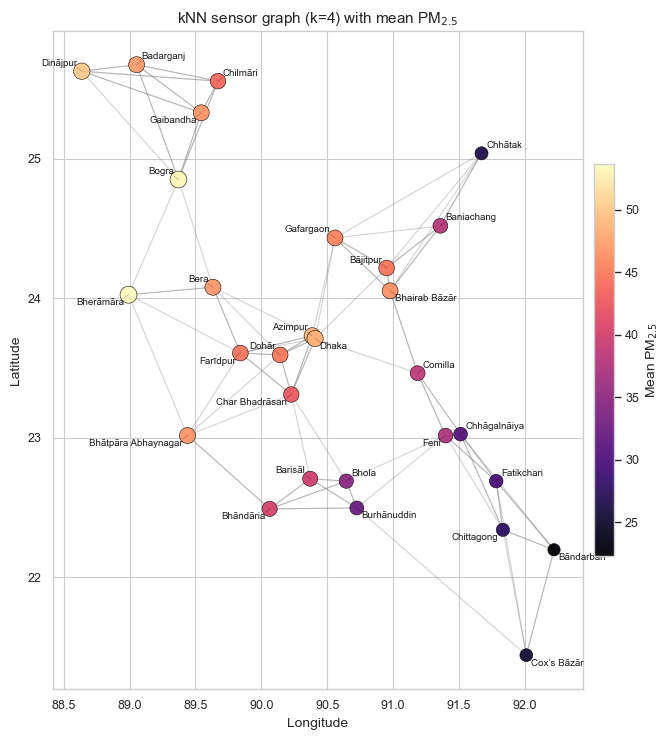

In [20]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Helper: simple "smart label" placement (no extra packages)
# -------------------------
def smart_offsets(lons, lats, dx=0.05, dy=0.035):
    """
    Assign labels to 8 possible offset directions, choosing the least crowded.
    Greedy heuristic: good enough for 29 cities without dependencies.
    """
    dirs = np.array([
        [ dx,  dy], [ dx, -dy], [-dx,  dy], [-dx, -dy],
        [ dx, 0.0], [-dx, 0.0], [0.0,  dy], [0.0, -dy]
    ])
    used = []  # list of placed label positions (lon, lat)

    offsets = []
    for x, y in zip(lons, lats):
        best = None
        best_cost = np.inf
        for d in dirs:
            px, py = x + d[0], y + d[1]
            # cost: inverse distance to already-placed labels + inverse distance to points
            # (penalize being too close)
            cost = 0.0
            for ux, uy in used:
                dist2 = (px-ux)**2 + (py-uy)**2
                cost += 1.0 / (dist2 + 1e-6)
            # also keep away from original points
            for ox, oy in zip(lons, lats):
                dist2p = (px-ox)**2 + (py-oy)**2
                cost += 0.25 / (dist2p + 1e-6)
            if cost < best_cost:
                best_cost = cost
                best = d
        offsets.append(best)
        used.append((x + best[0], y + best[1]))
    return np.array(offsets)

# -------------------------
# Build kNN graph
# -------------------------
city_coords = df.groupby("city_name")[["lat", "lon"]].median().reset_index()
city_coords = city_coords.sort_values("city_name").reset_index(drop=True)

mean_pm25 = df.groupby("city_name")["pm2_5"].mean()
city_coords["mean_pm25"] = city_coords["city_name"].map(mean_pm25)

lat0 = city_coords["lat"].mean()
m_per_deg_lat = 111320.0
m_per_deg_lon = 111320.0 * np.cos(np.deg2rad(lat0))
xy = np.c_[city_coords["lon"].values * m_per_deg_lon,
           city_coords["lat"].values * m_per_deg_lat]

k = 4
nbrs = NearestNeighbors(n_neighbors=k+1).fit(xy)
dists, idx = nbrs.kneighbors(xy)

fig, ax = plt.subplots(figsize=(6.8, 7.5))

# edges
for i in range(len(city_coords)):
    for j in idx[i, 1:]:
        p1 = city_coords.iloc[i]
        p2 = city_coords.iloc[j]
        ax.plot([p1["lon"], p2["lon"]], [p1["lat"], p2["lat"]],
                color="gray", alpha=0.35, linewidth=0.8, zorder=1)

# nodes
sizes = 30 + 2.2 * city_coords["mean_pm25"].values
sc = ax.scatter(city_coords["lon"], city_coords["lat"],
                s=sizes,
                c=city_coords["mean_pm25"].values,
                cmap="magma",
                edgecolor="black",
                linewidth=0.4,
                alpha=0.95,
                zorder=2)

# smart label offsets (in degrees) + light leader lines
lons = city_coords["lon"].values
lats = city_coords["lat"].values
offs = smart_offsets(lons, lats, dx=0.035, dy=0.025)

for (lon, lat, name), (dx, dy) in zip(city_coords[["lon","lat","city_name"]].values, offs):
    tx, ty = lon + dx, lat + dy
    ax.plot([lon, tx], [lat, ty], color="black", alpha=0.25, linewidth=0.6, zorder=2)  # leader
    ax.text(tx, ty, name, fontsize=7, ha="left" if dx >= 0 else "right",
            va="bottom" if dy >= 0 else "top",
            color="black", alpha=0.9, zorder=3)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"kNN sensor graph (k={k}) with mean PM$_{{2.5}}$")
cb = plt.colorbar(sc, ax=ax, fraction=0.035, pad=0.02)
cb.set_label("Mean PM$_{2.5}$")

plt.tight_layout()
plt.show()

The Strategy: "Smart Ablation"

We don't need to test every number. We only test the "Critical Zone" we discovered in your connectivity analysis.

The Test Candidates:

    K=3 (n_neighbors=4): The Baseline. This is the percolation threshold. It is the minimum connectivity required.

    K=4 (n_neighbors=5): The Hypothesis. This is your "Robust" choice (Threshold + 1). We expect this to win.

    K=6 (n_neighbors=7): The Control. This tests if adding more connections helps or hurts. (Likely hurts due to "oversmoothing" – a common GNN problem).


--- k=3 neighbors per city ---
Connected: True | Components: 1
Edges: 53 | Avg degree: 3.66 (min=3, max=5)
Max edge length: 140.86 km

--- k=4 neighbors per city ---
Connected: True | Components: 1
Edges: 72 | Avg degree: 4.97 (min=4, max=7)
Max edge length: 176.02 km

--- k=6 neighbors per city ---
Connected: True | Components: 1
Edges: 108 | Avg degree: 7.45 (min=6, max=12)
Max edge length: 200.07 km


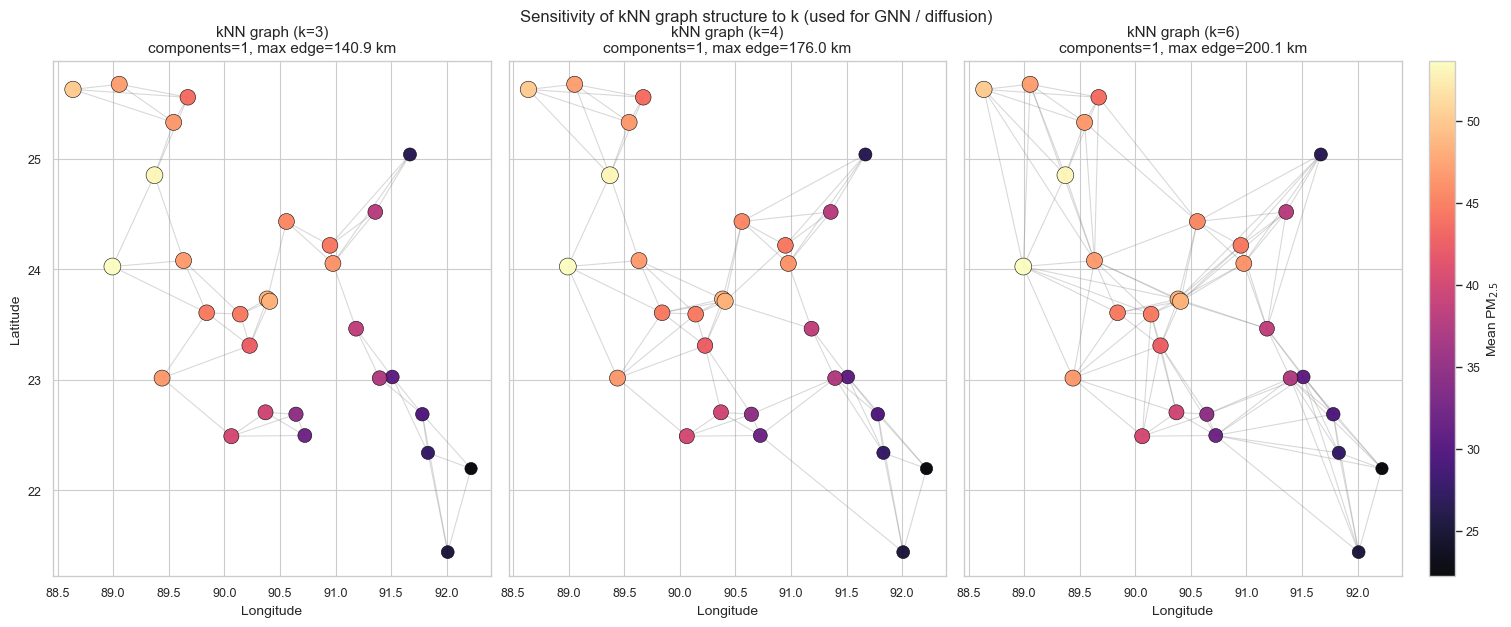

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# --- City coords + node statistic ---
city_coords = df.groupby("city_name")[["lat", "lon"]].median().reset_index()
city_coords = city_coords.sort_values("city_name").reset_index(drop=True)

mean_pm25 = df.groupby("city_name")["pm2_5"].mean()
city_coords["mean_pm25"] = city_coords["city_name"].map(mean_pm25)

# --- lat/lon -> meters (approx equirectangular) ---
lat0 = city_coords["lat"].mean()
m_per_deg_lat = 111320.0
m_per_deg_lon = 111320.0 * np.cos(np.deg2rad(lat0))

xy_m = np.c_[city_coords["lon"].values * m_per_deg_lon,
             city_coords["lat"].values * m_per_deg_lat]

# --- helper to build edges for given k ---
def build_knn_edges(xy_m, k):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(xy_m)  # +1 includes self
    dists, idx = nbrs.kneighbors(xy_m)

    edges = set()
    edge_lengths = []
    for i in range(len(xy_m)):
        for n in range(1, k+1):  # skip self
            j = int(idx[i, n])
            a, b = sorted((i, j))
            if (a, b) not in edges:
                edges.add((a, b))
                # length in km
                dij_km = float(np.linalg.norm(xy_m[a] - xy_m[b]) / 1000.0)
                edge_lengths.append(dij_km)

    return sorted(list(edges)), np.array(edge_lengths)

def graph_stats(n_nodes, edges, edge_lengths_km):
    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    G.add_edges_from(edges)

    n_comp = nx.number_connected_components(G)
    connected = nx.is_connected(G)
    degs = np.array([d for _, d in G.degree()])
    return {
        "connected": connected,
        "components": n_comp,
        "avg_degree": degs.mean(),
        "min_degree": degs.min(),
        "max_degree": degs.max(),
        "n_edges": len(edges),
        "max_edge_km": edge_lengths_km.max() if len(edge_lengths_km) else np.nan
    }

# --- plotting ---
ks = [3, 4, 6]
fig, axes = plt.subplots(1, len(ks), figsize=(15, 6), sharex=True, sharey=True,
                         constrained_layout=True)

# consistent node sizing/coloring across panels
sizes = 30 + 2.2 * city_coords["mean_pm25"].values
cvals = city_coords["mean_pm25"].values

for ax, k in zip(axes, ks):
    edges, edge_lengths_km = build_knn_edges(xy_m, k)
    stats = graph_stats(len(city_coords), edges, edge_lengths_km)

    print(f"\n--- k={k} neighbors per city ---")
    print(f"Connected: {stats['connected']} | Components: {stats['components']}")
    print(f"Edges: {stats['n_edges']} | Avg degree: {stats['avg_degree']:.2f} "
          f"(min={stats['min_degree']}, max={stats['max_degree']})")
    print(f"Max edge length: {stats['max_edge_km']:.2f} km")

    # edges
    for a, b in edges:
        p1 = city_coords.iloc[a]
        p2 = city_coords.iloc[b]
        ax.plot([p1["lon"], p2["lon"]], [p1["lat"], p2["lat"]],
                color="gray", alpha=0.30, linewidth=0.8, zorder=1)

    # nodes
    sc = ax.scatter(city_coords["lon"], city_coords["lat"],
                    s=sizes, c=cvals, cmap="magma",
                    edgecolor="black", linewidth=0.4, alpha=0.95, zorder=2)

    ax.set_title(f"kNN graph (k={k})\ncomponents={stats['components']}, max edge={stats['max_edge_km']:.1f} km")
    ax.set_xlabel("Longitude")

axes[0].set_ylabel("Latitude")
cb = fig.colorbar(sc, ax=axes, fraction=0.02, pad=0.02)
cb.set_label("Mean PM$_{2.5}$")

fig.suptitle("Sensitivity of kNN graph structure to k", y=1.02)

#plt.savefig("Fig_knn_k_ablation_panels.png", dpi=300, bbox_inches="tight")
plt.show()

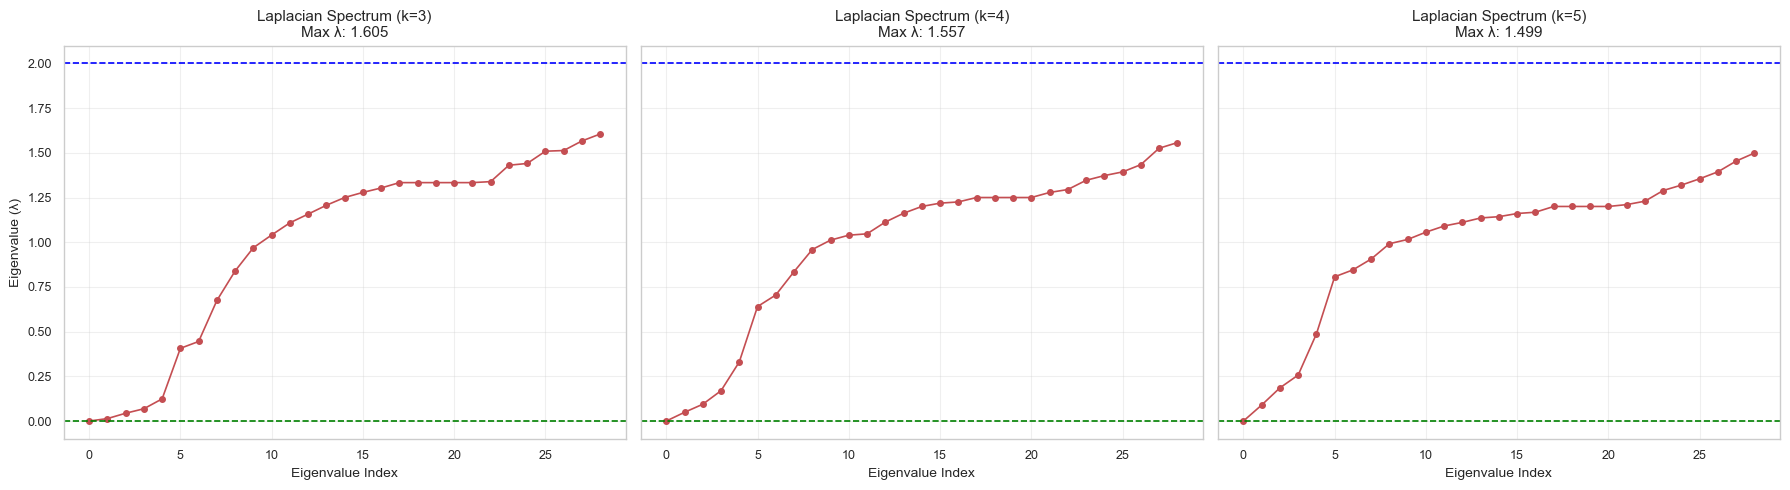

In [23]:
# --- Setup for coordinates ---
# Ensure df is your loaded base_dataset_2023_2025.csv
city_coords = df.groupby("city_name")[["lat", "lon"]].median().reset_index()
city_coords = city_coords.sort_values("city_name").reset_index(drop=True)
n_cities = len(city_coords)

# Approximate meters conversion (same as your previous code)
lat0 = city_coords["lat"].mean()
m_per_deg_lat = 111320.0
m_per_deg_lon = 111320.0 * np.cos(np.deg2rad(lat0))

xy_m = np.c_[city_coords["lon"].values * m_per_deg_lon,
             city_coords["lat"].values * m_per_deg_lat]

# --- Comparative Plotting ---
ks = [3, 4, 5]
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, k in zip(axes, ks):
    # 1. Build Adjacency Matrix
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(xy_m)
    dists, idx = nbrs.kneighbors(xy_m)
    
    adj = np.zeros((n_cities, n_cities))
    for i in range(n_cities):
        for n in range(1, k+1): # skip self
            j = idx[i, n]
            adj[i, j] = 1
            adj[j, i] = 1 # Symmetrize for stability
            
    # 2. Compute Symmetric Normalized Laplacian
    # L_sym = I - D^(-1/2) * A * D^(-1/2)
    degree = np.sum(adj, axis=1)
    d_inv_sqrt = np.power(degree, -0.5, where=degree!=0)
    D_inv_sqrt = np.diag(d_inv_sqrt)
    L_sym = np.eye(n_cities) - D_inv_sqrt @ adj @ D_inv_sqrt
    
    # 3. Calculate Eigenvalues
    eigenvalues = np.linalg.eigvalsh(L_sym)
    
    # 4. Plotting
    ax.plot(eigenvalues, 'ro-', label='Eigenvalues', markersize=4)
    ax.axhline(y=2.0, color='blue', linestyle='--', label='Stability Limit (2.0)')
    ax.axhline(y=0.0, color='green', linestyle='--', label='Lower Bound (0.0)')
    
    ax.set_title(f"Laplacian Spectrum (k={k})\nMax λ: {np.max(eigenvalues):.3f}")
    ax.set_xlabel("Eigenvalue Index")
    if k == 3:
        ax.set_ylabel("Eigenvalue (λ)")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# bbox_inches='tight' prevents axis labels from being cut off
#plt.savefig("Fig_Laplacian_Spectrum_k_ablation.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

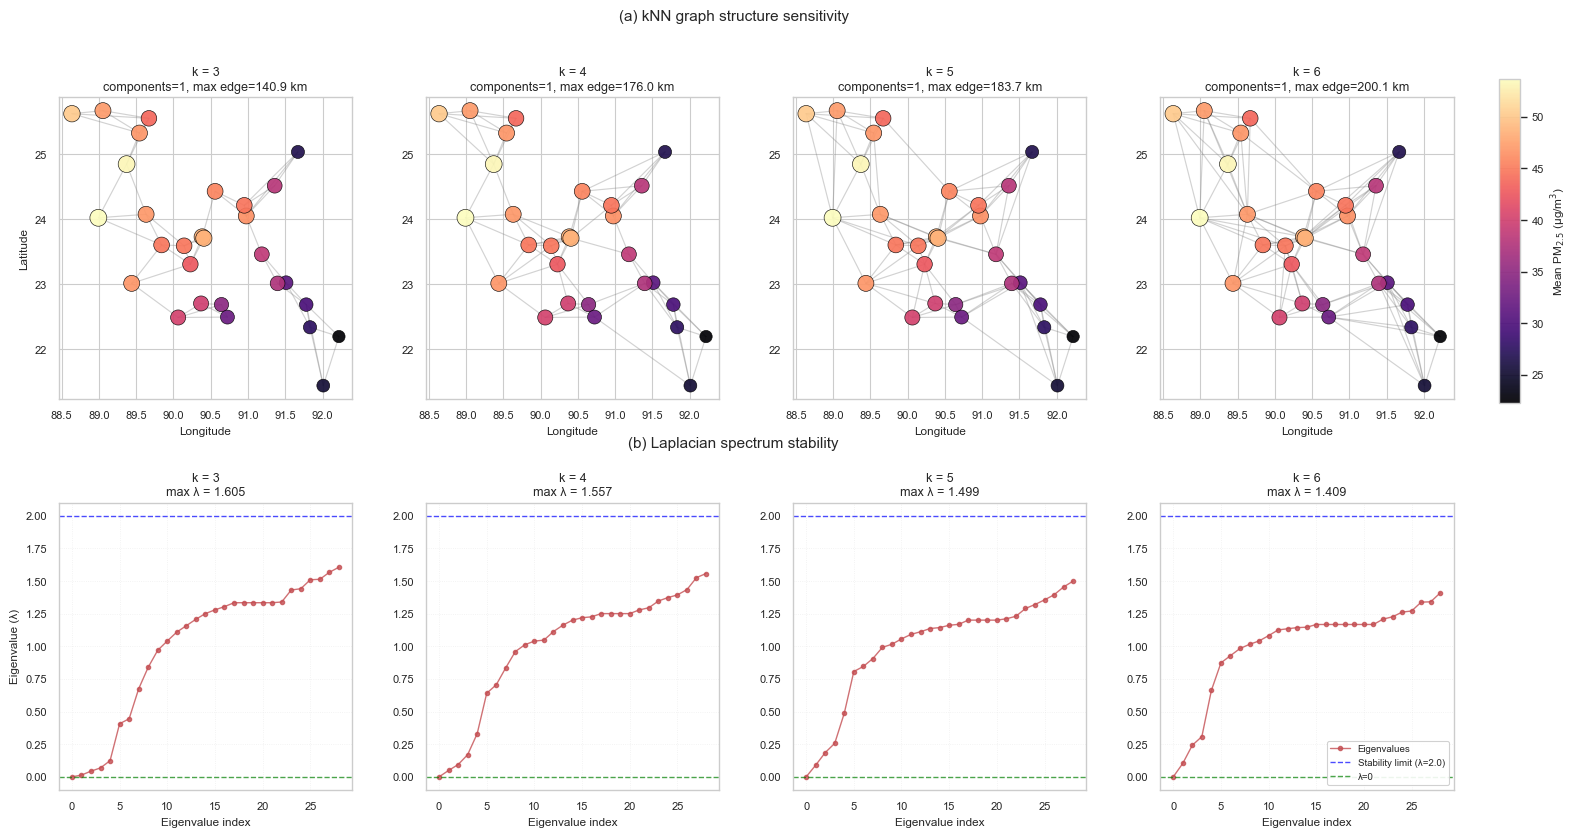

In [18]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx


# --- City coords + node statistic ---
city_coords = df.groupby("city_name")[["lat", "lon"]].median().reset_index()
city_coords = city_coords.sort_values("city_name").reset_index(drop=True)

mean_pm25 = df.groupby("city_name")["pm2_5"].mean()
city_coords["mean_pm25"] = city_coords["city_name"].map(mean_pm25)

# --- lat/lon -> meters (approx equirectangular) ---
lat0 = city_coords["lat"].mean()
m_per_deg_lat = 111320.0
m_per_deg_lon = 111320.0 * np.cos(np.deg2rad(lat0))
xy_m = np.c_[city_coords["lon"].values * m_per_deg_lon,
             city_coords["lat"].values * m_per_deg_lat]

# --- Helper functions ---
def build_knn_edges(xy_m, k):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(xy_m)
    dists, idx = nbrs.kneighbors(xy_m)
    edges = set()
    edge_lengths = []
    for i in range(len(xy_m)):
        for n in range(1, k+1):
            j = int(idx[i, n])
            a, b = sorted((i, j))
            if (a, b) not in edges:
                edges.add((a, b))
                dij_km = float(np.linalg.norm(xy_m[a] - xy_m[b]) / 1000.0)
                edge_lengths.append(dij_km)
    return sorted(list(edges)), np.array(edge_lengths)

def graph_stats(n_nodes, edges, edge_lengths_km):
    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    G.add_edges_from(edges)
    degs = np.array([d for _, d in G.degree()])
    return {
        "components": nx.number_connected_components(G),
        "avg_degree": degs.mean(),
        "max_edge_km": edge_lengths_km.max() if len(edge_lengths_km) else np.nan
    }

# --- Create unified figure (2 rows × 4 columns) ---
ks = [3, 4, 5, 6]
fig = plt.figure(figsize=(18, 9))
gs = fig.add_gridspec(2, 4, hspace=0.35, wspace=0.25, height_ratios=[1, 0.95])

# Node styling
sizes = 30 + 2.2 * city_coords["mean_pm25"].values
cvals = city_coords["mean_pm25"].values

# === PANEL A: kNN Graph Structure (top row) ===
for col, k in enumerate(ks):
    ax = fig.add_subplot(gs[0, col])
    edges, edge_lengths_km = build_knn_edges(xy_m, k)
    stats = graph_stats(len(city_coords), edges, edge_lengths_km)
    
    # Edges
    for a, b in edges:
        p1 = city_coords.iloc[a]
        p2 = city_coords.iloc[b]
        ax.plot([p1["lon"], p2["lon"]], [p1["lat"], p2["lat"]],
                color="gray", alpha=0.35, linewidth=0.85, zorder=1)
    
    # Nodes
    sc = ax.scatter(city_coords["lon"], city_coords["lat"],
                    s=sizes, c=cvals, cmap="magma",
                    edgecolor="black", linewidth=0.45, alpha=0.92, zorder=2)
    
    ax.set_title(f"k = {k}\ncomponents={stats['components']}, max edge={stats['max_edge_km']:.1f} km",
                 fontsize=9, pad=5)
    ax.set_xlabel("Longitude", fontsize=8.5)
    if col == 0:
        ax.set_ylabel("Latitude", fontsize=8.5)
    ax.tick_params(labelsize=8)

# === PANEL B: Laplacian Spectra (bottom row) ===
for col, k in enumerate(ks):
    ax = fig.add_subplot(gs[1, col])
    
    # Adjacency matrix
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(xy_m)
    _, idx = nbrs.kneighbors(xy_m)
    adj = np.zeros((len(city_coords), len(city_coords)))
    for i in range(len(city_coords)):
        for n in range(1, k+1):
            j = idx[i, n]
            adj[i, j] = 1
            adj[j, i] = 1
    
    # Symmetric normalized Laplacian
    degree = np.sum(adj, axis=1)
    d_inv_sqrt = np.power(degree, -0.5, where=degree>0)
    D_inv_sqrt = np.diag(d_inv_sqrt)
    L_sym = np.eye(len(city_coords)) - D_inv_sqrt @ adj @ D_inv_sqrt
    
    # Eigenvalues
    eigenvalues = np.linalg.eigvalsh(L_sym)
    
    # Plot
    ax.plot(eigenvalues, 'ro-', markersize=3, linewidth=1.0, alpha=0.8)
    ax.axhline(y=2.0, color='blue', linestyle='--', linewidth=1.0, alpha=0.7)
    ax.axhline(y=0.0, color='green', linestyle='--', linewidth=1.0, alpha=0.7)
    
    ax.set_title(f"k = {k}\nmax λ = {eigenvalues[-1]:.3f}", fontsize=9, pad=5)
    ax.set_xlabel("Eigenvalue index", fontsize=8.5)
    if col == 0:
        ax.set_ylabel("Eigenvalue (λ)", fontsize=8.5)
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.6)
    ax.tick_params(labelsize=8)
    if col == 3:
        ax.legend(['Eigenvalues', 'Stability limit (λ=2.0)', 'λ=0'],
                  fontsize=7, loc='lower right', framealpha=0.9)

# Main panel labels (non-bold)
fig.text(0.5, 0.965, "(a) kNN graph structure sensitivity", 
         ha='center', fontsize=11, fontweight='normal')
fig.text(0.5, 0.49, "(b) Laplacian spectrum stability", 
         ha='center', fontsize=11, fontweight='normal')

# Colorbar for Panel A
cbar_ax = fig.add_axes([0.925, 0.54, 0.012, 0.36])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("Mean PM$_{2.5}$ (µg/m$^3$)", fontsize=8.5)
cb.ax.tick_params(labelsize=8)

plt.savefig("Fig_knn_laplacian_sensitivity.tiff", dpi=600, bbox_inches="tight", facecolor="white", pil_kwargs={"compression": "tiff_lzw"})
plt.show()